[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/weaviate/recipes/blob/main/weaviate-features/multi-vector/multi-vector-colipali-rag.ipynb)

# Multi-vector RAG: Using Weaviate to search a collection of PDF documents 

**Author**

Tobias Christiani <tobias@weaviate.io>

**Dependencies**

Python `3.13`
Weaviate `1.29.0`  
weaviate-client `4.11.0`  
[ColQwen2-v1.0](https://huggingface.co/vidore/colqwen2-v1.0)  
[Qwen/Qwen2.5-VL-3B-Instruct](https://huggingface.co/Qwen/Qwen2.5-VL-3B-Instruct)  
... see Pipfile for full list of Python packages

## Introduction

This notebook will demonstrate how to use Weaviate's multi-vector feature to 
effectively index a collection of PDF documents in order to support textual 
queries against the contents of the documents, including both text and figures.

In this demonstration we will be working with a dataset of the [top-40 most 
cited AI papers on arXiv](https://arxiv.org/abs/2412.12121) from the period 
2023-01-01 to 2024-09-30. 

We will be performing retrieval against this collection of PDF documents by 
embedding both the individual pages of the documents and our queries into the 
same multi-vector space, reducing the problem to approximate nearest-neighbor 
search on ColBERT-style multi-vectors under the MaxSim similarity measure. 

The approach we will be using to generate embeddings is outlined in the recent 
paper [ColPali: Efficient Document Retrieval with Vision Language Models](https://arxiv.org/abs/2407.01449). 
The paper demonstrates that it is possible to both simplify and 
speed up traditional approaches to preprocessing PDF documents for retrieval, 
which involves the use of OCR (Optical Character Recognition) software and 
separate processing of text and figures, by instead feeding images (screenshots) 
of entire pages to a Vision Language Model that produces a ColBERT-style embedding.

<img src="figures/colipali_pipeline.jpeg" width="700px">

Specifically, we will be using the publicly available model 
[ColQwen2-v1.0](https://huggingface.co/vidore/colqwen2-v1.0) to generate 
embeddings.

## Retrieval example

As an example of what we are going to build consider the following actual demo 
query and resulting PDF page from our collection (nearest neighbor):

- Query: "How does DeepSeek-V2 compare against the LLaMA family of LLMs?"
- Nearest neighbor:  "DeepSeek-V2: A Strong Economical and Efficient 
Mixture-of-Experts Language Model" (arXiv: 2405.04434), Page: 1.

By inspecting the first page of the 
[DeepSeek-V2 paper](https://arxiv.org/abs/2405.04434) we see that it does indeed 
contain a figure that is relevant for answering our query:

<img src="figures/deepseek_efficiency.jpeg" width="700px">

# Extension to Retrieval Augmented Generation (RAG)

The above example gives us the most relevant pages to begin looking at in order 
to answer our query. Vision language models are now powerful enough that we can 
instead give the query and relevant pages to such a model and have it produce an 
answer to our query in plain text! 

In order to accomplish this we are going to feed the top results into the 
state-of-the-art VLM [Qwen/Qwen2.5-VL-3B-Instruct](https://huggingface.co/Qwen/Qwen2.5-VL-3B-Instruct).

# Demonstration overview

The demonstration will proceed through the following steps in order to set up a
 running retrieval example:

1. Loading the ColQwen model from huggingface and adding convenience functions 
to vectorize images and queries.
2. Load an example dataset of PDF pages from huggingface.
3. Spinning up a local Weaviate server and creating a collection of 
bring-your-own multivectors.
4. Querying the collection and displaying results.
5. Setting up Qwen2.5-VL to support retrieval-augmented generation.

# Prerequisites

- The Python packages listed in the Pipfile in this directory.
- A machine capable of running neural networks using 5-10 GB of memory.
- A local instance of Weaviate version >= 1.29.0

To install all dependencies as listed in the Pipfile use `pipenv install` to set 
up the local environment for this notebook. 

The demonstration uses two different vision language models that both require 
several gigabytes of memory. See the documentation for each individual model and 
the general pytorch docs in order to figure out how to best run the models on 
your hardware.

In [1]:
# Load the ColQWEN model
import torch
from colpali_engine.models import ColQwen2, ColQwen2Processor
import os

# Get rid of process forking deadlock warnings.
os.environ["TOKENIZERS_PARALLELISM"] = "false"


# A convenience class to wrap the functionality we will use from
# https://huggingface.co/vidore/colqwen2-v1.0
class Colqwen:
    def __init__(self):
        """Load the model and processor from huggingface."""
        # About a 5 GB download and similar memory usage.
        self.model = ColQwen2.from_pretrained(
            "vidore/colqwen2-v1.0",
            torch_dtype=torch.bfloat16,
            device_map="mps",  # or "cuda:0" if using a NVIDIA GPU
            attn_implementation="eager",  # or "flash_attention_2" if available
        ).eval()
        self.processor = ColQwen2Processor.from_pretrained("vidore/colqwen2-v1.0")

    # A batch size of one appears to be most performant when running on an M4.
    # Note: Reducing the image resolution speeds up the vectorizer and produces
    # fewer multi-vectors.
    def multi_vectorize_image(self, img):
        """Return the multi-vector image of the supplied PIL image."""
        image_batch = self.processor.process_images([img]).to(self.model.device)
        with torch.no_grad():
            image_embedding = self.model(**image_batch)
        return image_embedding[0]

    def multi_vectorize_text(self, query):
        """Return the multi-vector embedding of the query text string."""
        query_batch = self.processor.process_queries([query]).to(self.model.device)
        with torch.no_grad():
            query_embedding = self.model(**query_batch)
        return query_embedding[0]

    def maxsim(self, query_embedding, image_embedding):
        """Compute the MaxSim between the query and image multi-vectors."""
        return self.processor.score_multi_vector(
            [query_embedding], [image_embedding]
        ).item()


# Instantiate the model to be used below.
colqwen = Colqwen()

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.48, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


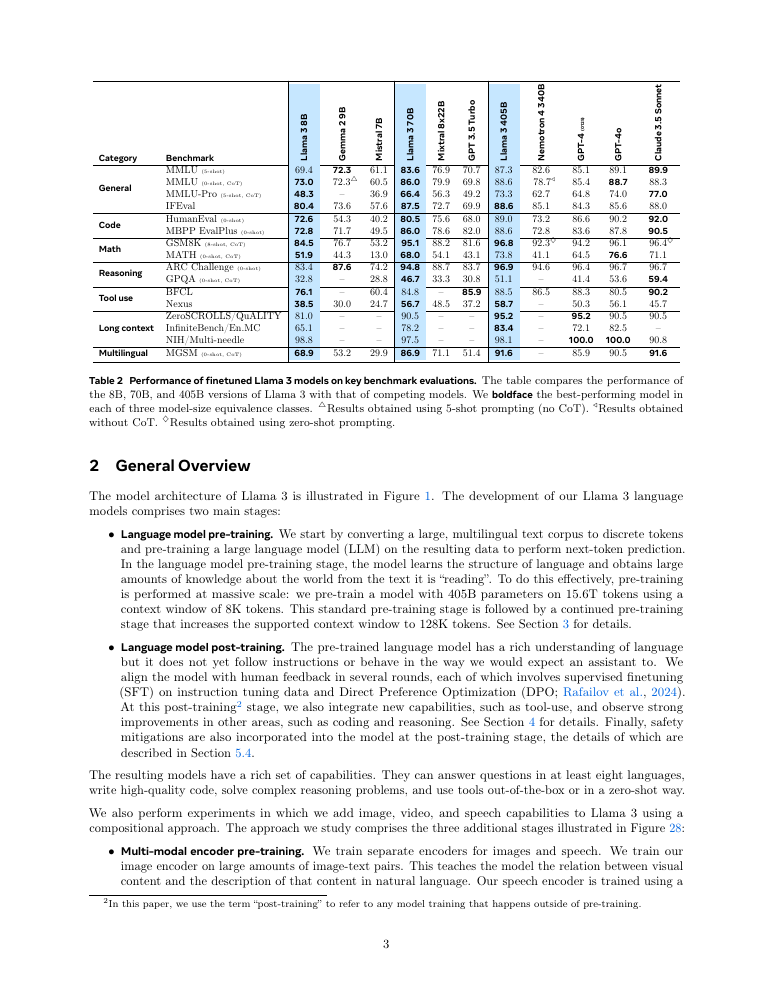

In [2]:
# Load a dataset from huggingface
from datasets import load_dataset

page_data = load_dataset("weaviate/arXiv-AI-papers-multi-vector").with_format(
    "numpy", columns=["colqwen_embedding"], output_all_columns=True
)["train"]

img = page_data[12]["page_image"]
display(img)

In [3]:
# Verify that the embedding of images and queries works as intended.
page_embedding = colqwen.multi_vectorize_image(img)
print(page_embedding.shape)  # torch.Size([755, 128])

queries = [
    "A table with LLM benchmark results.",
    "A figure detailing the architecture of a neural network.",
]

query_embeddings = [colqwen.multi_vectorize_text(q) for q in queries]
print(query_embeddings[0].shape)  # torch.Size([20, 128])

# The page matches the first query but not the second. Verify that the
# similarity scores reflect this.
print(colqwen.maxsim(query_embeddings[0], page_embedding))  # 13.4375
print(colqwen.maxsim(query_embeddings[1], page_embedding))  # 9.5625

torch.Size([755, 128])
torch.Size([30, 128])
20.0
13.0625


In [5]:
# Make sure that you have weaviate >= 1.29.0 running locally.
!docker run --detach -p 8080:8080 -p 50051:50051 cr.weaviate.io/semitechnologies/weaviate:1.29.0

48bf63fa2d2ae3ce5dfa6d8f8462ea4367b4acfb18f4b50e71d03aa3ecf503fe


In [6]:
# Create the Pages collection that will hold our page embeddings.
import weaviate
import weaviate.classes.config as wc
from weaviate.classes.config import Configure

client = weaviate.connect_to_local()
client.collections.create(
    name="Pages",
    properties=[
        wc.Property(name="page_id", data_type=wc.DataType.INT),
        wc.Property(name="dataset_index", data_type=wc.DataType.INT),
        wc.Property(name="paper_title", data_type=wc.DataType.TEXT),
        wc.Property(name="paper_arxiv_id", data_type=wc.DataType.TEXT),
        wc.Property(name="page_number", data_type=wc.DataType.INT)
    ],
    vectorizer_config=[Configure.NamedVectors.none(
        name="colqwen",
        vector_index_config=Configure.VectorIndex.hnsw(
            multi_vector=Configure.VectorIndex.MultiVector.multi_vector()
        )
    )]
)
client.close()

In [7]:
# Load data into weaviate.
import numpy as np
client = weaviate.connect_to_local()
pages = client.collections.get("Pages")

# Map of page ids to images to support displaying the image corresponding to a 
# particular page id.
page_images = {}

with pages.batch.dynamic() as batch:
    for i in range(len(page_data)):
        p = page_data[i]
        page_images[p["page_id"]] = p["page_image"]

        batch.add_object(
            properties={
                "page_id": p["page_id"],
                "paper_title": p["paper_title"], 
                "paper_arxiv_id": p["paper_arxiv_id"], 
                "page_number": p["page_number"]
                }, vector={"colqwen": p["colqwen_embedding"]})
        
        if i % 25 == 0:
            print(f"Added {i+1}/{len(page_data)} Page objects to Weaviate.") 

client.close()

Added 1/399 Page objects to Weaviate.
Added 26/399 Page objects to Weaviate.
Added 51/399 Page objects to Weaviate.


/Users/tobiaschristiani/.local/share/virtualenvs/multi-vector-CMoV6Oxu/lib/python3.13/site-packages/weaviate/warnings.py:280: UserWarning: Bat003: The dynamic batch-size could not be refreshed successfully: error ZeroDivisionError('division by zero')
  warnings.warn(


Added 76/399 Page objects to Weaviate.
Added 101/399 Page objects to Weaviate.
Added 126/399 Page objects to Weaviate.
Added 151/399 Page objects to Weaviate.
Added 176/399 Page objects to Weaviate.
Added 201/399 Page objects to Weaviate.
Added 226/399 Page objects to Weaviate.
Added 251/399 Page objects to Weaviate.
Added 276/399 Page objects to Weaviate.
Added 301/399 Page objects to Weaviate.
Added 326/399 Page objects to Weaviate.
Added 351/399 Page objects to Weaviate.
Added 376/399 Page objects to Weaviate.


In [8]:
# Example of retrieving relevant PDF pages to answer a query.
import weaviate
from weaviate.classes.query import MetadataQuery

query_text = "How does DeepSeek-V2 compare against the LLaMA family of LLMs?"

query_embedding = colqwen.multi_vectorize_text(query_text).cpu().float().numpy()

with weaviate.connect_to_local() as client:
    pages = client.collections.get("Pages")
    response = pages.query.near_vector(
        near_vector=query_embedding,
        target_vector="colqwen",
        limit=10,
        return_metadata=MetadataQuery(distance=True),
    )
    for i, o in enumerate(response.objects):
        print(
            f"{i+1}) MaxSim: {-o.metadata.distance:.2f}, "
            + f"Title: \"{o.properties['paper_title']}\" "
            + f"(arXiv: {o.properties['paper_arxiv_id']}), "
            + f"Page: {int(o.properties['page_number'])}"
        )

1) MaxSim: 29.66, Title: "DeepSeek-V2: A Strong Economical and Efficient Mixture-of-Experts Language Model" (arXiv: 2405.04434), Page: 1
2) MaxSim: 28.03, Title: "DeepSeek-V2: A Strong Economical and Efficient Mixture-of-Experts Language Model" (arXiv: 2405.04434), Page: 4
3) MaxSim: 27.12, Title: "DeepSeek-Coder: When the Large Language Model Meets Programming -- The Rise of Code Intelligence" (arXiv: 2401.14196), Page: 10
4) MaxSim: 26.44, Title: "LLaMA: Open and Efficient Foundation Language Models" (arXiv: 2302.13971), Page: 4
5) MaxSim: 26.35, Title: "DeepSeek-Coder: When the Large Language Model Meets Programming -- The Rise of Code Intelligence" (arXiv: 2401.14196), Page: 2
6) MaxSim: 26.33, Title: "Qwen Technical Report" (arXiv: 2309.16609), Page: 8
7) MaxSim: 26.15, Title: "Llama 2: Open Foundation and Fine-Tuned Chat Models" (arXiv: 2307.09288), Page: 4
8) MaxSim: 26.09, Title: "LLaMA: Open and Efficient Foundation Language Models" (arXiv: 2302.13971), Page: 1
9) MaxSim: 26.0

In [9]:
# Setting up Qwen2.5-VL-3B-Instruct for generating answers from a query string 
# plus a collection of (images of) PDF pages.
# Note: I had to install the transformers package using the command
# pip install git+https://github.com/huggingface/transformers accelerate
# in order to get this bleeding-edge model to work.
import torch
from transformers import Qwen2_5_VLForConditionalGeneration, AutoTokenizer, AutoProcessor
from qwen_vl_utils import process_vision_info
import base64
from io import BytesIO

class QwenVL:
    def __init__(self):
        # Adjust the settings to your available architecture, see the link
        # https://huggingface.co/Qwen/Qwen2.5-VL-3B-Instruct for examples.
        self.model = Qwen2_5_VLForConditionalGeneration.from_pretrained(
            "Qwen/Qwen2.5-VL-3B-Instruct",
            torch_dtype=torch.bfloat16,
            device_map="mps",
            attn_implementation="eager"
        )

        min_pixels = 256*28*28
        max_pixels = 1280*28*28
        self.processor = AutoProcessor.from_pretrained(
            "Qwen/Qwen2.5-VL-3B-Instruct", min_pixels=min_pixels, max_pixels=max_pixels)

    def query_images(self, query, images):
        """Generate a textual response to the query (text) based on the information in the supplied list of PIL images."""
        # Preparation for inference.
        # Convert the images to base64 strings.
        content = []
        for img in images:
            buffer = BytesIO()
            img.save(buffer, format="jpeg")
            img_base64 = base64.b64encode(buffer.getvalue()).decode("utf-8")
            content.append({"type": "image", "image": f"data:image;base64,{img_base64}"})

        content.append({"type": "text", "text": query})
        messages = [{"role": "user", "content": content}]

        text = self.processor.apply_chat_template(
            messages, tokenize=False, add_generation_prompt=True
        )
        image_inputs, video_inputs = process_vision_info(messages)
        inputs = self.processor(
            text=[text],
            images=image_inputs,
            videos=video_inputs,
            padding=True,
            return_tensors="pt",
        )
        inputs = inputs.to("mps")

        # Inference: Generation of the output.
        generated_ids = self.model.generate(**inputs, max_new_tokens=128)
        generated_ids_trimmed = [
            out_ids[len(in_ids):] for in_ids, out_ids in zip(inputs.input_ids, generated_ids)
        ]
        return self.processor.batch_decode(
            generated_ids_trimmed, skip_special_tokens=True, clean_up_tokenization_spaces=False
        )[0]

# Instantiate the model to be used below.
qwenvl = QwenVL()

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

# RAG examples

Try this out yourself below.

### Query 1: How did DeepSeek-V2 manage to outperform existing state of the art LLMs?


The most relevant documents for the query "How did DeepSeek-V2 manage to outperform existing state of the art LLMs?" by order of relevance:

1) MaxSim: 30.03, Title: "DeepSeek-V2: A Strong Economical and Efficient Mixture-of-Experts Language Model" (arXiv: 2405.04434), Page: 4
2) MaxSim: 29.13, Title: "DeepSeek-V2: A Strong Economical and Efficient Mixture-of-Experts Language Model" (arXiv: 2405.04434), Page: 1
3) MaxSim: 27.68, Title: "DeepSeek-V2: A Strong Economical and Efficient Mixture-of-Experts Language Model" (arXiv: 2405.04434), Page: 5

The answer from Qwen2.5-VL-3B-Instruct based on these documents:
```
DeepSeek-V2 achieved this by optimizing the attention modules and Feed-Forward 
Networks (FFNs) within the Transformer framework, introducing Multi-head 
Latent Attention (MLA) and DeepSeekMoE architectures, and employing expert 
segmentation and shared expert isolation for higher potential in expert 
specialization. Additionally, it demonstrated strong performance with only 21B
activated parameters, saving 42.5% of training costs, reducing the KV cache by 
93.3%, and boosting the maximum generation throughput to 5.76 times
```

### Query 2: Describe the figure on the front page of the paper "Adding Conditional Control to Text-to-Image Diffusion Models"

The most relevant documents for the query "Describe the figure on the front page of the paper "Adding Conditional Control to Text-to-Image Diffusion Models"" by order of relevance:

1) MaxSim: 31.99, Title: "Adding Conditional Control to Text-to-Image Diffusion Models" (arXiv: 2302.05543), Page: 1
2) MaxSim: 25.26, Title: "Stable Video Diffusion: Scaling Latent Video Diffusion Models to Large Datasets" (arXiv: 2311.15127), Page: 1
3) MaxSim: 24.71, Title: "SDXL: Improving Latent Diffusion Models for High-Resolution Image Synthesis" (arXiv: 2307.01952), Page: 8

The answer from Qwen2.5-VL-3B-Instruct based on these documents:
```
The figure on the front page of the paper "Adding Conditional Control to 
Text-to-Image Diffusion Models" is titled "Figure 1: Controlling Stable 
Diffusion with learned conditions." It illustrates how users can control the 
image generation of large pretrained diffusion models using learned 
conditions, such as Canny edges, human pose, and other attributes.

Here's a detailed description of the figure:

### Figure 1: Controlling Stable Diffusion with learned conditions

#### Top Row:
1. **Input Canny edge**: A black-and-white sketch of a deer.
2. **Default**: The default output without any additional conditions.
3.
```
### Query 3: Why do we need the retrieval step when performing retrieval augmented generation?

The most relevant documents for the query "Why do we need the retrieval step when performing retrieval augmented generation?" by order of relevance:

1) MaxSim: 24.53, Title: "Retrieval-Augmented Generation for Large Language Models: A Survey" (arXiv: 2312.10997), Page: 2
2) MaxSim: 23.41, Title: "Retrieval-Augmented Generation for Large Language Models: A Survey" (arXiv: 2312.10997), Page: 1
3) MaxSim: 21.06, Title: "Retrieval-Augmented Generation for Large Language Models: A Survey" (arXiv: 2312.10997), Page: 4

The answer from Qwen2.5-VL-3B-Instruct based on these documents:

```
The retrieval step is necessary in Retrieval-Augmented Generation (RAG) because 
it allows the model to access and utilize external knowledge from databases or 
other sources. This external knowledge can provide context, enhance the accuracy 
of the generated response, and help the model understand the user's query 
better. By incorporating this external knowledge, RAG can improve its 
performance on tasks that require domain-specific knowledge or require 
continuous updates based on new information.
```

In [10]:
import weaviate
from weaviate.classes.query import MetadataQuery

# Some example queries. Answering a query takes about a minute on an M4 Macbook.

# query_text = "How did DeepSeek-V2 manage to outperform existing state of the art LLMs?"
# query_text = "Describe the figure on the front page of the paper \"Adding Conditional Control to Text-to-Image Diffusion Models\""

query_text = "Why do we need the retrieval step when performing retrieval augmented generation?"
query_embedding = colqwen.multi_vectorize_text(query_text).cpu().float().numpy()

with weaviate.connect_to_local() as client:
    pages = client.collections.get("Pages")
    response = pages.query.near_vector(
        near_vector=query_embedding, 
        target_vector="colqwen",
        limit=3,
        return_metadata=MetadataQuery(distance=True)
    )
    print(f"The most relevant documents for the query \"{query_text}\" by order of relevance:\n")
    result_images = [] 
    for i, o in enumerate(response.objects):
        p = o.properties
        print(
            f"{i+1}) MaxSim: {-o.metadata.distance:.2f}, "
            + f"Title: \"{p['paper_title']}\" "
            + f"(arXiv: {p['paper_arxiv_id']}), "
            + f"Page: {int(p['page_number'])}"
        )
        result_images.append(page_images[p["page_id"]])
    
print(f"\nThe answer from Qwen2.5-VL-3B-Instruct based on these documents:\n{qwenvl.query_images(query_text, result_images)}")

The most relevant documents for the query "Why do we need the retrieval step when performing retrieval augmented generation?" by order of relevance:

1) MaxSim: 24.53, Title: "Retrieval-Augmented Generation for Large Language Models: A Survey" (arXiv: 2312.10997), Page: 2
2) MaxSim: 23.41, Title: "Retrieval-Augmented Generation for Large Language Models: A Survey" (arXiv: 2312.10997), Page: 1
3) MaxSim: 21.06, Title: "Retrieval-Augmented Generation for Large Language Models: A Survey" (arXiv: 2312.10997), Page: 4

The answer from Qwen2.5-VL-3B-Instruct based on these documents:
The retrieval step is necessary in Retrieval-Augmented Generation (RAG) because it allows the model to access and utilize external knowledge from databases or other sources. This external knowledge can provide context, enhance the accuracy of the generated response, and help the model understand the user's query better. By incorporating this external knowledge, RAG can improve its performance on tasks that requi